In [262]:
import requests
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import argparse
import pandas as pd
import requests
import math
from io import StringIO
import warnings
import logging
import pathlib
import shutil
import geopandas as gpd
import contextily as ctx
from glob import glob
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [217]:
input_shapefile_dir = '../data/shapefiles'
input_file = '../data/state_county/ar_ashley.csv.xz'
lat_lon_df_ex = pd.read_csv(input_file)
lat_lon_df_ex

# Retrieve all zip file references

In [219]:
prefix = 'https://www2.census.gov/geo/tiger/TIGER2020PL/LAYER/TABBLOCK/2020/'
r= requests.get(prefix)
soup = BeautifulSoup(r.content)
shape_zips = []
for a in soup.find_all('a', href=True):
    if not '.zip' in a['href'] or len(a['href'])!= 28: # filter for the entire state ones
        continue
    shape_zips.append(a['href'])
print(len(shape_zips))

3221


In [222]:
test_zip = [z for z in shape_zips if '05003' in z]
test_zip

['tl_2020_05003_tabblock20.zip']

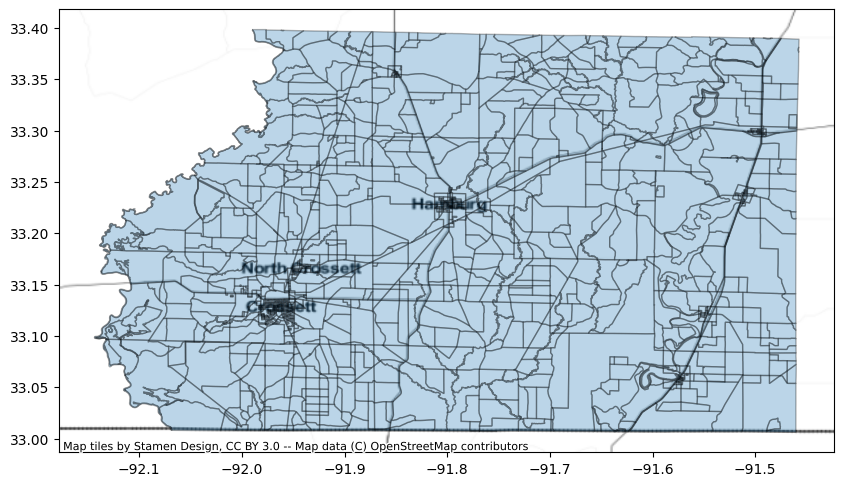

In [223]:
state_df = gpd.read_file(prefix+test_zip[0])
state_df.crs= 4326
ax = state_df.plot(figsize=(10, 10), alpha=0.3, edgecolor='black')
ctx.add_basemap(ax, zoom=10, crs=state_df.crs.to_string(), source=ctx.providers.Stamen.Toner)

In [89]:
fsdf = pd.read_csv('../data/fips_state.csv')
fsdf

,fips,state,abbr
0,1,alabama,al
1,2,alaska,ak
2,4,arizona,az
3,5,arkansas,ar
4,6,california,ca
5,8,colorado,co
6,9,connecticut,ct
7,10,delaware,de
8,11,district_of_columbia,dc
9,12,florida,fl


In [224]:
def generate_state_df(state_fip, progress=False):
    prefix = 'https://www2.census.gov/geo/tiger/TIGER2020PL/LAYER/TABBLOCK/2020/'
    state_shape_files = [v for v in shape_zips if v.split('_')[2][:2]==state_fip]
    dfs = []
    
    if progress:
        state_shape_files= tqdm(state_shape_files)
    
    for file in state_shape_files:
        dfs.append(gpd.read_file(prefix+file))
                   
    df = pd.concat(dfs)
    return df

In [226]:
ar = generate_state_df('02', True)
ar

100%|██████████| 30/30 [00:19<00:00,  1.56it/s]


,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,02,013,000100,1077,020130001001077,Block 1077,G5040,NaN,NaN,NaN,S,0,1711768,+55.2612919,-162.8877612,"POLYGON ((-162.89888 55.25698, -162.89444 55.2..."
1,02,013,000100,1078,020130001001078,Block 1078,G5040,NaN,NaN,NaN,S,0,256570,+55.2467322,-162.9025994,"POLYGON ((-162.90658 55.24572, -162.90600 55.2..."
2,02,013,000100,1023,020130001001023,Block 1023,G5040,NaN,NaN,NaN,S,0,610757,+55.2889930,-162.7977268,"POLYGON ((-162.80986 55.29102, -162.80938 55.2..."
3,02,013,000100,1026,020130001001026,Block 1026,G5040,NaN,NaN,NaN,S,0,2022883,+55.3017277,-162.7749984,"POLYGON ((-162.79788 55.30116, -162.79752 55.3..."
4,02,013,000100,1051,020130001001051,Block 1051,G5040,NaN,NaN,NaN,S,0,27869,+55.1001745,-162.6247626,"POLYGON ((-162.62658 55.10214, -162.62549 55.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,02,290,000300,1072,022900003001072,Block 1072,G5040,NaN,NaN,NaN,S,4286887212,6396082,+66.1357038,-157.2018595,"POLYGON ((-158.25644 66.09130, -158.25623 66.0..."
1495,02,290,000300,3052,022900003003052,Block 3052,G5040,NaN,NaN,NaN,S,15745,0,+64.3273180,-158.7325400,"POLYGON ((-158.73369 64.32796, -158.73327 64.3..."
1496,02,290,000300,3064,022900003003064,Block 3064,G5040,NaN,NaN,NaN,S,669119104,0,+64.1471978,-159.0508541,"POLYGON ((-159.62600 64.08639, -159.62015 64.0..."
1497,02,290,000300,3012,022900003003012,Block 3012,G5040,NaN,NaN,NaN,S,3883255470,0,+64.4487065,-159.2432620,"POLYGON ((-159.96229 64.73143, -159.95983 64.7..."


In [227]:
def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  # returns list of shapely point

# Test the function results here

In [299]:
input_file = '../data/state_county/ar_ashley.csv.xz'
lat_lon_df_ex = pd.read_csv(input_file)
cgdf = gpd.GeoDataFrame(
    lat_lon_df_ex,
    geometry=gpd.points_from_xy(lat_lon_df_ex.longitude, lat_lon_df_ex.latitude),
)
ar = generate_state_df('05', True)

100%|██████████| 75/75 [01:05<00:00,  1.15it/s]


In [300]:
ar

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,UR20,UACE20,UATYPE20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,05,001,480100,1257,050014801001257,Block 1257,G5040,NaN,NaN,NaN,S,27192,0,+34.3944347,-091.2951087,"POLYGON ((-91.29620 34.39375, -91.29602 34.394..."
1,05,001,480600,1000,050014806001000,Block 1000,G5040,NaN,NaN,NaN,S,2700838,0,+34.3794170,-091.3563361,"POLYGON ((-91.36532 34.37351, -91.36532 34.373..."
2,05,001,480100,1046,050014801001046,Block 1046,G5040,NaN,NaN,NaN,S,3960920,0,+34.3923243,-091.3472113,"POLYGON ((-91.36498 34.38846, -91.36493 34.390..."
3,05,001,480700,2001,050014807002001,Block 2001,G5040,NaN,NaN,NaN,S,168517,0,+34.3896559,-091.2956321,"POLYGON ((-91.29721 34.38645, -91.29718 34.386..."
4,05,001,480700,2002,050014807002002,Block 2002,G5040,NaN,NaN,NaN,S,2675933,0,+34.3787351,-091.3034985,"POLYGON ((-91.31245 34.37202, -91.31245 34.372..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515,05,149,952500,3034,051499525003034,Block 3034,G5040,NaN,NaN,NaN,S,968763,0,+35.0453495,-093.3399181,"POLYGON ((-93.35317 35.04849, -93.35315 35.050..."
1516,05,149,952500,3047,051499525003047,Block 3047,G5040,NaN,NaN,NaN,S,3979858,0,+35.0273548,-093.3041381,"POLYGON ((-93.31853 35.03790, -93.31776 35.037..."
1517,05,149,952500,3050,051499525003050,Block 3050,G5040,NaN,NaN,NaN,S,5258131,0,+35.0299465,-093.2578272,"POLYGON ((-93.28383 35.03352, -93.28382 35.033..."
1518,05,149,952500,3068,051499525003068,Block 3068,G5040,NaN,NaN,NaN,S,579395,0,+35.0242391,-093.2802527,"POLYGON ((-93.28628 35.02296, -93.28618 35.027..."


In [284]:
cgdf

,state,county,zip,longitude,latitude,address,id,geometry
0,ar,ashley,71635,-91.963568,33.123666,"301 west 9th avenue,crossett,ar,71635",ar_ashley,POINT (-91.96357 33.12367)
1,ar,ashley,71635,-91.949543,33.121913,"1100 camp road,crossett,ar,71635",ar_ashley,POINT (-91.94954 33.12191)
2,ar,ashley,71635,-91.950245,33.121784,"1100 camp road,crossett,ar,71635",ar_ashley,POINT (-91.95025 33.12178)
3,ar,ashley,71635,-91.949614,33.118393,"1300 pecan street,crossett,ar,71635",ar_ashley,POINT (-91.94961 33.11839)
4,ar,ashley,71635,-91.960783,33.126432,"701 main street,crossett,ar,71635",ar_ashley,POINT (-91.96078 33.12643)
...,...,...,...,...,...,...,...,...
12985,ar,ashley,71661,-91.616955,33.122743,"433 ashley 351 road,parkdale,ar,71661",ar_ashley,POINT (-91.61696 33.12274)
12986,ar,ashley,71661,-91.484689,33.127085,"381 ashley 45 road,parkdale,ar,71661",ar_ashley,POINT (-91.48469 33.12709)
12987,ar,ashley,71646,-91.748783,33.269232,"521 ashley 70 road,hamburg,ar,71646",ar_ashley,POINT (-91.74878 33.26923)
12988,ar,ashley,71635,-92.043261,33.116475,"118 pinewood road,crossett,ar,71635",ar_ashley,POINT (-92.04326 33.11648)


In [263]:
isinstance(cgdf, gpd.GeoDataFrame)

True

In [303]:
from itertools import groupby

def all_equal(iterable):
    g = groupby(iterable)
    return next(g, True) and not next(g, False)

In [313]:
def process_dataframe(
    lat_lon_df,
    state_df,
):
    warnings.filterwarnings("ignore")    
    df = lat_lon_df.sjoin(state_df, how="left", predicate="intersects")
    # search for the county fip, assuming the first non-nan one is correct, and extracting it using the first 5 characters
    # print(df[~df['GEOID20'].isnull()])
#     county_fip = df[~df['GEOID20'].isnull()]['GEOID20'].values[0][:5]
    
#     # from the official shapefiles, isolate based on county fips
#     county_df = state_df[state_df['GEOID20'].str[:5]==county_fip]
#     print(county_df)
    
    # merge the county fips and the address we have, so we can count how many nan's exist for blocks
    # df = pd.concat([df, county_df])
    # remove unecssary columns
    df = df[
        ["address", "GEOID20", 'longitude', 'latitude']
    ]    
    df.drop_duplicates(inplace=True)
    df = df.rename(columns={"GEOID20": "geoid20"})    
    # Check that all non-null values have the same county fips
    # assert all_equal(df[~df['geoid20'].isnull()]['geoid20'].str[:5]), print(df['geoid20'].apply(lambda x: x[:5]).unique())    
    return df

tdf = process_dataframe(cgdf, ar)
tdf

,address,geoid20,longitude,latitude
0,"1544 upper kingston rd, prattville, al, 36067",NaN,-86.466624,32.517489
1,"1424 autauga heights rd, prattville, al, 36066",NaN,-86.453164,32.516843
2,"334 northington st, prattville, al, 36067",NaN,-86.466778,32.469375
3,"2402 co rd 59, prattville, al, 36067",NaN,-86.491162,32.612263
4,"1546 upper kingston rd, prattville, al, 36067",NaN,-86.466561,32.517683
...,...,...,...,...
16612,"684 co rd 165, prattville, al, 36067",NaN,-86.610806,32.467913
16613,"120 co rd 13, autaugaville, al, 36003",NaN,-86.651870,32.438722
16614,"164 palmer rd, autaugaville, al, 36003",NaN,-86.684288,32.444265
16615,"3043 co rd 78, autaugaville, al, 36003",NaN,-86.692553,32.437646


In [305]:
assert all_equal(tdf['geoid20'].str[:5])

In [ ]:
#     perc_coverage = len(lat_lon_df['geoid20'].unique()) / len(state_df['GEOID20'].unique()) * 100    
#     report = pd.DataFrame({
#         'county_fip': county_fip, 
#         'perc_coverage:': perc_coverage, 
#         'median': vc.median(), 
#         'std': vc.std(),
#     },index=[0])

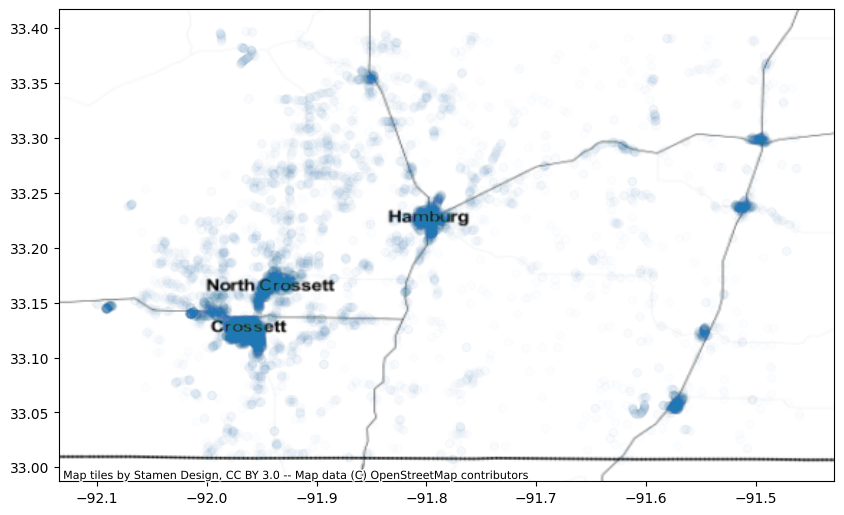

In [40]:
cgdf.crs= 4326
ax = cgdf.plot(figsize=(10, 10), alpha=0.01)
ctx.add_basemap(ax, zoom=10, crs=cgdf.crs.to_string(), source=ctx.providers.Stamen.Toner)

# Itereate through all files in data/state_county, and export it to data/county_address/ under <county_fip>.csv.xz

In [317]:
address_dir = '../data/state_county'
pbar = tqdm(sorted([v for v in os.listdir(d) if v.split('.')[-1] == 'xz']))

prev_fip = None
state_df = None

file_counter = 0

for c in pbar:
    pbar.set_description('Processing: %s' % c)
    state_fip = str(fsdf[fsdf['abbr'] == c.split('_')[0]]['fips'].values[0]).zfill(2)
    

    if prev_fip != state_fip:
        prev_fip = state_fip # set the new previous to the current
        state_df = generate_state_df(state_fip, False) # then generate the new state data frame
        file_counter = 0 # reset file counters
  
    lat_lon_df = pd.read_csv(os.path.join(address_dir, c)) # load existing address csv
    cgdf = gpd.GeoDataFrame(
        lat_lon_df,
        geometry=gpd.points_from_xy(lat_lon_df.longitude, lat_lon_df.latitude),
    )
    tdf = process_dataframe(cgdf, state_df)
    
    # if no geoids, skip to the next
    if tdf[~tdf['geoid20'].isnull()].size <= 0:
        continue

    # ecause some files have multiple different counties overlap, instead create indices, join them, and then separately export
    name = '%s_%s' % (state_fip, str(file_counter).zfill(2))
    tdf.to_csv('../data/county_address/%s.csv.xz'% name, index=False)
    file_counter+= 1
    

Processing: wy_weston.csv.xz: 100%|██████████| 1802/1802 [1:58:40<00:00,  3.95s/it]                      
